In [20]:
#data manipulation library
import pandas as pd
import numpy as np


#plotting libraries
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

#modelling libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# generating polynomial features
from sklearn.preprocessing import PolynomialFeatures


import warnings
warnings.filterwarnings("ignore")

In [21]:
import pandas as pd

desc = pd.read_csv('description.csv')

name_mapper = {i:j for i,j in zip(desc['Nr'], desc['Name'])}

train = pd.read_csv('http://kdd.ics.uci.edu/databases/tic/ticdata2000.txt', sep = '\t')

test = pd.read_csv('http://kdd.ics.uci.edu/databases/tic/ticeval2000.txt', sep = '\t')
target = pd.read_csv('http://kdd.ics.uci.edu/databases/tic/tictgts2000.txt', )



train.columns = range(1,len(train.columns)+1)
test.columns = range(1,len(test.columns)+1)


train.columns = train.columns.map(name_mapper)

test.columns = test.columns.map(name_mapper)
test['CARAVAN'] = target

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [22]:
# reading train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [23]:
train.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
3,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
4,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0


### 1. Which features are relevant for the prediction task? Select top 10 features based on your understanding. Show visualizations or statistics to support your selection. [2 0 Marks]

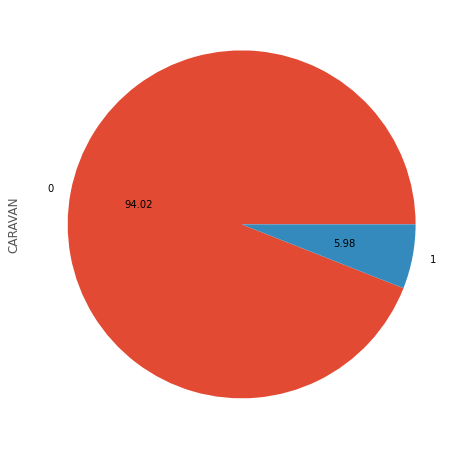

In [24]:
# lets look at the target
train['CARAVAN'].value_counts().plot.pie(autopct='%.2f', figsize = (10,8))
plt.show()

Imbalanced dataset(even if we predict all to be '0' we will get 94% accuracy) 

In [25]:
# sns.pairplot(train, hue="CARAVAN", height=2, diag_kind="kde");

In [26]:
# f, ax = plt.subplots(figsize=(15, 12))
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(cor_mat,linewidths=.5, ax=ax);

In [27]:
# find top variables based on correlation

train.corrwith(train["CARAVAN"]).abs().sort_values(ascending=False).head(11)

CARAVAN     1.000000
PPERSAUT    0.150969
APERSAUT    0.144249
APLEZIER    0.105697
PWAPART     0.096434
MKOOPKLA    0.095915
PBRAND      0.094543
PPLEZIER    0.091359
MOPLLAAG    0.090525
MINKGEM     0.090193
AWAPART     0.089358
dtype: float64

In [28]:
xtrain = train.drop('CARAVAN', axis=1)
ytrain = train['CARAVAN'].copy()

xtest = test.drop('CARAVAN', axis=1)
ytest = test['CARAVAN'].copy()

### 2. Train a Logistic Regression (LogReg) model with L1 regularization. Find the best model using grid search on C values. Analyze which features have nonzero coefficients for the best model. Are they in synch with your selected features from question 1? [30 Marks]

In [29]:
def lr_model_with_gridsearch(xtrain, ytrain, xtest, ytest, c_params = np.logspace(-3,3,7), plot_importance=False ):
    grid={"C":c_params }

    logreg=LogisticRegression(penalty='l1', solver = 'liblinear')
    logreg_cv=GridSearchCV(logreg,grid,cv=10)
    logreg_cv.fit(xtrain, ytrain)

    print("tuned hyerparameters :(best parameters) ",logreg_cv.best_params_)
    print("train accuracy :",logreg_cv.best_score_)
    
    logreg_test_preds = logreg_cv.predict(xtest)
    print("test accuracy : ",accuracy_score(ytest, logreg_test_preds))
    
    if plot_importance:
        best_model = logreg_cv.best_estimator_
        feature_coef = pd.Series(best_model.coef_.ravel(), index = xtrain.columns)
        feature_coef.abs().sort_values(ascending=False)[:10].plot.bar(title = 'Top Ten - Features')
        plt.show()
    return 
    

tuned hyerparameters :(best parameters)  {'C': 0.001}
train accuracy : 0.9402165007397452
test accuracy :  0.9404851212803201


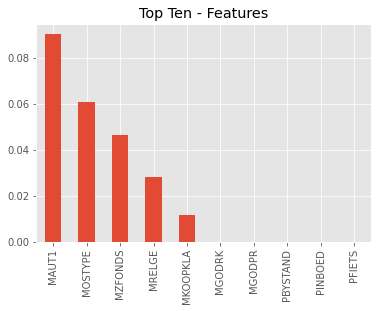

In [30]:
lr_model_with_gridsearch(xtrain, ytrain, xtest, ytest, plot_importance=True )

Among top ten we selected One is matching that is :
### MKOOPKLA    

### 3. Generate polynomial features and use LogReg again with L1. See if accuracy increase. [20 Marks]

In [31]:
poly = PolynomialFeatures(interaction_only=True, degree =2)
poly

PolynomialFeatures(interaction_only=True)

In [32]:
xtrain_poly = poly.fit_transform(xtrain)
xtrain_poly = pd.DataFrame(xtrain_poly , columns = poly.get_feature_names())

In [33]:
xtest_poly = poly.transform(xtest)
xtest_poly = pd.DataFrame(xtest_poly , columns = poly.get_feature_names())

In [34]:
# using best C from Q2
lr_model_with_gridsearch(xtrain_poly, ytrain, xtest_poly, ytest, c_params = [0.001],plot_importance=False )

tuned hyerparameters :(best parameters)  {'C': 0.001}
train accuracy : 0.9402165007397452
test accuracy :  0.9404851212803201


Accuracy Did not change with addition of polynomial features


### 4. Train a Decision Tree and see if you can get a better result. Show feature importance from the decision tree. Are they in synch with the features from Q1 and Q2? [30 Marks]

In [35]:
def decision_tree_model(xtrain, ytrain, xtest, ytest, params = {},plot_importance=False ):
    
    dt = DecisionTreeClassifier( **params)
    dt.fit(xtrain, ytrain)

    print("train accuracy :",dt.score(xtrain, ytrain))
    
    dt_test_preds = dt.predict(xtest)
    print("test accuracy : ",accuracy_score(ytest, dt_test_preds))
    
    if plot_importance:
        feature_coef = pd.Series(dt.feature_importances_, index = xtrain.columns)
        feature_coef.abs().sort_values(ascending=False)[:10].plot.bar(title = 'Top Ten - Features')
        plt.show()
    return 

In [36]:
decision_tree_model(xtrain, ytrain, xtest, ytest,plot_importance=False )

train accuracy : 0.9914104105823741
test accuracy :  0.8917229307326832


from the looks of it, it seems like decision tree performance is bad on test data.

but if you ask me i would argue that logictic regression is just predicting all zeroes thats why it has 94% accuracy while decision tree is trying to build more generalized model.

default decision tree overfits on train, best we should add some params

In [37]:
decision_tree_model(xtrain, ytrain, xtest, ytest,params = {'max_depth':10}, plot_importance=False )

train accuracy : 0.9592853461604536
test accuracy :  0.9209802450612653


By adding just one param which prunes the tree and avoid it to overfit we have improved our test performance